# Distributed Computing Inspired by Biology

This notebook showcases the different bio-inspired algorithms discussed in
> Függer, M., Nowak, T., Thuillier, K. (2025). Distributed Computing Inspired by Biology. Seminars in Cell and Developmental Biology.

It requires the *Python 3* packages: `numpy`, `networkx`, `scipy`, `mobspy`, `ipykernel`, and `ipywidgets`.

It can also be executed online (*without any installation*), using *Binder* [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/BioDisCo/dc_bio/HEAD).

In [1]:
import numpy as np

from src.notebook_utils import *  # noqa: F403


## Hodkin-Huxley Neuron Model

Mammalian brains contain a large number of neurons that interact to enable complex behavior.
An early, simple model of a neuron is the Hodgkin-Huxley model introduced in
> Alan L Hodgkin and Andrew F Huxley. A quantitative description of membrane current and its application to conduction and excitation in nerve.  
> The Journal of physiology, 117(4):500, 1952

It describes the kinetics of the membrane potential over time, for a given input current density.
The model is in terms of a system of non-linear \emph{ordinary differential equations} (ODEs) that describe the charging and discharging of a capacitance.
An arguably simplistic model of a single neuron with an input current density $I(t)$ and a resulting membrane potential $V(t)$ is described by
$$
    \begin{align*}
    I(t) &= \left \{ \begin{array}{l} \text{threshold} \times \text{factor} \quad \text{if } 10.0 \leq t \\ 0 \quad \text{else} \end{array} \right . \\
    C \cdot \frac{dV(t)}{dt} &= I(t) - I_\text{K}(V(t)) - I_\text{Na}(V(t)) - I_\text{L}(V(t)) \quad \quad \text{with } V(t_0) = V_0
    \end{align*}
$$
as the charging of a capacitance $C$ by $I$.
The non-linear discharging current densities of the sodium, potassium, and leak channels are described by
$$
\begin{align*}
    I_\text{Na}(V) &= g_\text{Na} \cdot m^3(t) \cdot h(t) \cdot (V - V_\text{Na})\\
    I_\text{K}(V) &= g_\text{K} \cdot n^4(t) \cdot h(t) \cdot (V - V_\text{K})\\
    I_\text{L}(V) &= g_\text{L} \cdot (V - V_\text{L})
\end{align*}
$$
where the dynamics of $m(t)$, $n(t)$, and $h(t)$ are defined by
$$
\begin{align*}
    \frac{dm(t)}{dt} &= \alpha_m(V(t)) \cdot (1 - m(t)) - \beta_m(V(t)) \cdot m(t) \quad & \text{with } m(t_0) = m_0 \\
    \frac{dn(t)}{dt} &= \alpha_n(V(t)) \cdot (1 - n(t)) - \beta_n(V(t)) \cdot n(t) \quad & \text{with } n(t_0) = n_0 \\
    \frac{dh(t)}{dt} &= \alpha_h(V(t)) \cdot (1 - h(t)) - \beta_h(V(t)) \cdot h(t) \quad & \text{with } h(t_0) = h_0
\end{align*}
$$
and $\alpha$ and $\beta$ are scaled and shifted exponential functions of $V(t)$.

> See `src/hodgkin_huxley.py` for full implementation details.

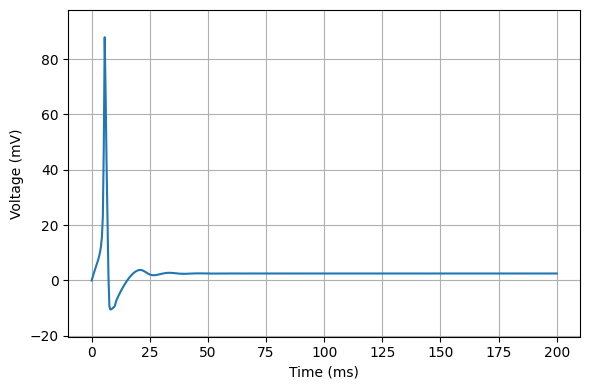

In [2]:
interact_hodgkin_huxley(duration=200, steps=500)  # noqa: F405

## Differentiable Loss Functions: Gradient Descent

When the function to optimize is differentiable, gradient descent can be used to iteratively minimize it.
In gradient descent, the parameters are updated in the direction opposite to the gradient of the loss function ($- \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$).  
Let $0 < \tau \ll 1$ be the learning rate, let $f$ be the loss function, and let $\theta^{(i)}$ be the parameters of $f$ at the $i$-th iteration.
At each iteration $i$, the parameters $\theta^{(i)}$ are updated as follows:
$$
    \theta^{(i+1)} := \theta^{(i)} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}
$$

In this notebook (as in the associated paper), we consider the differentiable function $f : \mathbb{R}^2 \to \mathbb{R}$ defined by:
$$
    f(x, y) = \sin(\pi \cdot x) \cdot \cos(\pi \cdot y) + (x^2 + y^2)
$$
whose derivatives are:
$$
    \begin{align*}
        \frac{\partial f(x, y)}{\partial x} &=  \pi \cdot \cos(\pi \cdot x) \cdot \cos(\pi \cdot y) + 2 \cdot x
        \quad\quad\quad\quad\quad 
        & \frac{\partial f(x, y)}{\partial y} &= -\pi \cdot \sin(\pi \cdot x) \cdot \sin(\pi \cdot y) + 2 \cdot y
    \end{align*}
$$

In [3]:
def f(x: float, y: float) -> float:  # noqa: D103
    return np.sin(np.pi * x) * np.cos(np.pi * y) + (x**2 + y**2)


def df_dx(x: float, y: float) -> float:  # noqa: D103
    return np.pi * np.cos(np.pi * x) * np.cos(np.pi * y) + 2 * x


def df_dy(x: float, y: float) -> float:  # noqa: D103
    return -np.pi * np.sin(np.pi * x) * np.sin(np.pi * y) + 2 * y

The paper discusses 3 variants of the gradient descent: *standard* gradient descent, a variant *with momentum*, and a variant *with noisy step*.
For each method the iteration from $\theta^{(i)}$ to $\theta^{(i+1)}$ is given by:
1. **Standard:** 
    * $\theta^{(i+1)} := \theta^{(i)} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$

2. **With momentum:**  
    This variant introduces a velocity vector $\nu_\theta^{(i)}$ to incorporate past updates into the current step.
    This helps accelerate convergence and may avoid local minima.  
    Let $\rho \in [0, 1]$ be the momentum rate (referred to as `Momentum` below).  
    Initialize $\nu_\theta^{(0)} = 0$, then update as:
    * $\nu^{(i+1)}_\theta := \rho \cdot \nu^{(i)}_{\theta} - \tau \cdot \frac{\partial f(\theta^{(i)})}{\theta^{(i)}}$
    * $\theta^{(i+1)} := \theta^{(i)} + \nu^{(i+1)}_{\theta}$

3. **With noise:**  
    This variant introduces Gaussian noise every $n$ steps to help escape local minima.  
    Let $n \in \mathbb{N}$ be the number of iterations between random steps (referred to as `Noise` below), and let $X^{(i)} \sim \mathcal{N}(0, 1)$ be a standard Gaussian vector.  
    At each iteration $i > 0$:
    * $\theta^{(i+1)} := \theta^{(i)} - \tau \cdot \begin{cases} X^{(i)} & \text{if } i \equiv 0 \pmod{n} \\ \frac{\partial f(\theta^{(i)})}{\theta^{(i)}} & \text{otherwise} \end{cases}$

> See `src/gradient_descent.py` for full implementation details.

In the cell below, the `Animation` checkbox can be used to display step-by-step the gradient descent algorithms.  
⚠️ **Warning:** This animation may take some time to run. ⚠️

In [4]:
interact_gradient_descent(f, df_dx, df_dy)  # noqa: F405

## General Loss Functions

Let's now consider the case when the function to optimize is not necessarily differentiable.

We still consider the function $f : \mathbb{R}^2 \to \mathbb{R}$ defined previously as:
$$
    f(x, y) = \sin(\pi \cdot x) \cdot \cos(\pi \cdot y) + (x^2 + y^2)
$$

In [5]:
def f(x: float, y: float) -> float:  # noqa: D103
    return np.sin(np.pi * x) * np.cos(np.pi * y) + (x**2 + y**2)

### Differential Evolution

Differential Evolution is an optimization method that iteratively estimates the optimum of a real-valued function $f$.  
At each iteration, it generates new population of improving candidate solutions using three steps: *mutation* $\rightarrow$ *recombination* $\rightarrow$ *selection*.


**Algorithm outlines**  

* **Initialization:**  
    Randomly sample $n \in \mathbb{N}^*$ points in the solution space. 
    Let $X^{(0)} = \left \{x^{(0)}_j \right \}_{j = 1}^n$ be our initial population.
    
* **Iteration:**  
    For each iteration $i \geq 0$, the next population $X^{(i+1)} = \left \{ x_j^{(i+1)} \right \}_{j=1}^{n}$ is generated from $X^{(i)}$ as follows:
    1. **Mutation:**  
        For each individual $x_j^{(i)}$, randomly select three distinct individuals $x_{r1}^{(i)}$, $x_{r2}^{(i)}$, and $x_{r3}^{(i)}$ from the population.
        Construct a mutant vector:
        $$
            v^{(i+1)}_j = x^{(i)}_{r1} + \mu \cdot (x^{(i)}_{r2} - x^{(i)}_{r3})
        $$
        where $\mu \in \mathbb{R}^+$ is the mutation rate (referred to as `Mutation` below).
    
    2. **Recombination:**  
        Create a candidate vector by mixing components of $x_j^{(i)}$ and $v_j^{(i+1)}$.
        For each component $k$:
        $$
            v^{(i+1)}_{j,k} := \begin{cases} v^{(i+1)}_{j,k} & \text{with probability } \phi \\ x^{(i)}_{j,k} & \text{with probability } 1 - \phi \end{cases}
        $$
        where $\phi \in [0, 1]$ is the recombination rate (referred to as `Recombination` belows).

    3. **Selection:**  
        Keep the candidate individual that yields the lowest loss *w.r.t.* $f$:
        $$
            x^{(i+1)}_{j} = \begin{cases} v^{(i+1)}_{j} & \text{if } f(v^{(i+1)}_{j}) \leq f(x^{(i)}_{j}) \\ x^{(i)}_{j} & \text{otherwise} \end{cases}
        $$

> See `src/differential_evolution.py` for full implementation details.

In [6]:
interact_differential_evolution(f)  # noqa: F405

### Particle Swarm

Particle Swarm Optimization is a stochastic optimization method.
It is used to find the global minimum (or maximum) of a real-valued function over a continuous space.

Here, each candidate solution is a particle moving through the search space.
At each iteration, particles adjust their position based on their momentum, the best value they found, and the best value found by all neighboring particles.


**Algorithm outlines**  
Given $n$ the number of particles, we denote by $x^{(i)}_j$ and $\nu^{(i)}_j$ the position and velocity of particle $j$, *respectively*, at the $i$-th iteration.
We also denote by $p^{(i)}_j$ the best position found by particle $j$ so far (***personal best***), and by $g$ the best position found by the entire swarm (***global best***).

* **Initialization:**  
    For all particles $j$: $x^{(0)}_j$ is randomly chosen in the solution space; $\nu^{(0)}_j = 0$; and $p^{(0)}_j = x^{(0)}_j$.  
    The global best value $g$ is initialized as $g = p^{(0)}_{\argmax_j f(p^{(0)}_j)}$.

* **Iteration:**  
    For all particles $j$:
    - Position and velocity updates *w.r.t.* personal and global bests.
        $$
            \begin{align*}
                \nu^{(i+1)}_j &= \rho \cdot \nu^{(i)}_j + w_p \cdot X^{(i)}_{j} \cdot (p^{(i)}_j - x^{(i)}_j)  + w_g \cdot Y^{(i)}_{j} \cdot (g - x^{(i)}_j) \\
                x^{(i+1)}_j &= x^{(i)}_j + \nu^{(i+1)}_j
            \end{align*}
        $$
        where $X^{(i)}_{j}, Y^{(i)}_{j} \sim \mathcal{N}(0, 1)$ are two random vectors, $\rho$ is the momentum rate, and $w_p, w_g \in \mathbb{R}^+$ are the attraction strengths toward the personal and global bests, *respectively*.

    - Personal and global best updates.
        $$
            p^{(i+1)}_j := \begin{cases} x^{(i+1)}_{j} & \text{if } f(x^{(i+1)}_{j}) \leq f(p^{(i)}_{j}) \\ p^{(i)}_{j} & \text{otherwise} \end{cases}
            \quad \quad \quad \quad
            g := \begin{cases} p^{(i+1)}_{j} & \text{if } f(p^{(i+1)}_{j}) \leq f(g) \\ g & \text{otherwise} \end{cases} \\
        $$


> See `src/particle_swarm.py` for full implementation details.

In [7]:
interact_particle_swarm(f)  # noqa: F405

## Consensus

### Graphs Generation

In [8]:
graphs, sequence = interact_consensus_graphs()  # noqa: F405

### 1D Methods

#### Equal-weight

In [9]:
interact_consensus_1D(sequence, "mean")  # noqa: F405

#### Midpoint

In [10]:
interact_consensus_1D(sequence, "midpoint")  # noqa: F405

### 2D Methods: MidExtreme vs ApproachExtreme

#### MidExtreme

In [11]:
interact_consensus_2D(sequence, "midextreme")  # noqa: F405

#### ApproachExtreme

In [12]:
interact_consensus_2D(sequence, "approachextreme")  # noqa: F405

## Chemical Reaction Networks

### ABC Model

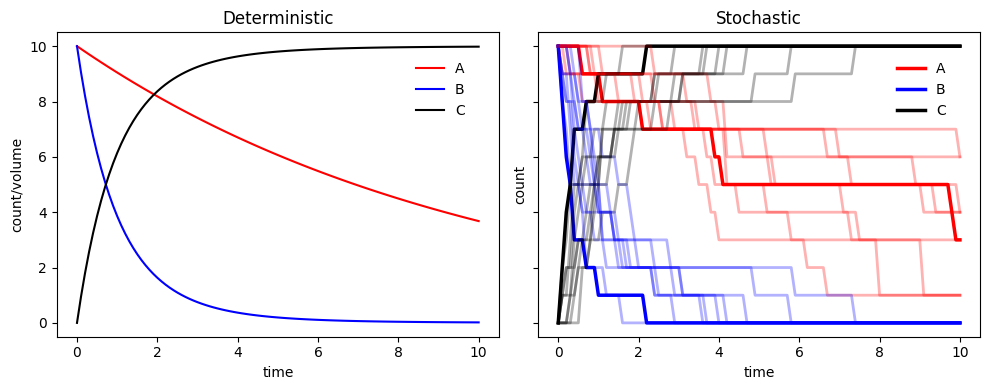

In [13]:
interact_crn_abc(duration=10)  # noqa: F405

### Annihilation Model

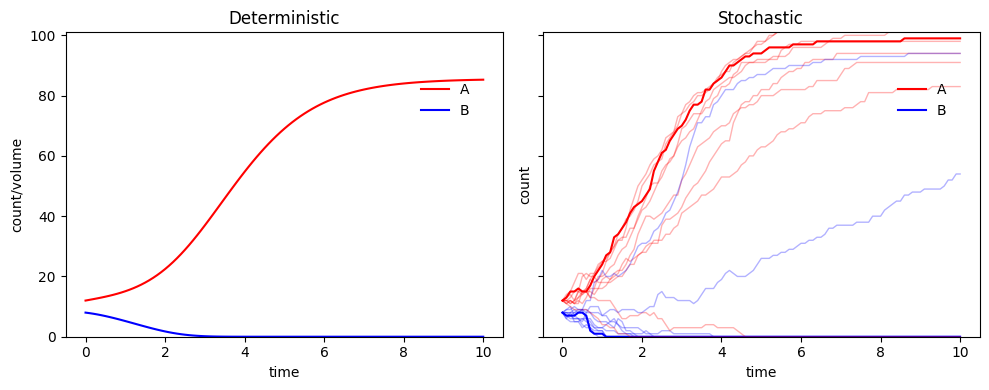

In [14]:
interact_crn_mutual_annihilation(duration=10)  # noqa: F405

## Maximal Independent Set - MIS

In [15]:
interact_maximal_independent_set()  # noqa: F405